In [ ]:
print ("hello")

hello


In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# A small package to create visualizations of PyTorch execution graphs and traces.
# https://github.com/szagoruyko/pytorchviz
!pip install torchviz | tail -n 1
from torchviz import make_dot  # visualize the PyTorch models

# Torchinfo provides information complementary to what is provided by print(your_model) in PyTorch,
# similar to Tensorflow's model.summary() API to view the visualization of the model,
# which is helpful while debugging your network.
# https://github.com/TylerYep/torchinfo
!pip install torchinfo | tail -n 1
from torchinfo import summary  # display the summary of PyTorch models

# Set random seed (reproduce the same results every time)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True


# Device allocation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


!nvidia-smi


!wget https://raw.githubusercontent.com/a-ymst/IntroductionToDeepLearning/main/myutils.py
import myutils

cuda:0
Fri Aug 18 11:24:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!cp -rv /content/drive/MyDrive/IntroductionToDL2023/ASL/archive_200/ ./ASL_Model

In [ ]:
!git clone "https://github.com/cs-wsucs/Intro2DLData.git"

fatal: destination path 'Intro2DLData' already exists and is not an empty directory.


In [ ]:
!find -type d -name '.ipynb_checkpoints' -delete

import torchvision.transforms as transforms     # Transforms
import torchvision.datasets as datasets         # for using dataset such as MNIST and CIFER-10
from torch.utils.data import DataLoader

###################################################
### Transforms
###################################################
OurASL_transform_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # data augmentation
    transforms.RandomRotation(degrees=30),   # data augmentation
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False) # data augmentation
])

OurASL_transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])


###################################################
### Dataset (both for training and testing)
###################################################

#data_root = './ASL_Model/asl_alphabet_train/asl_alphabet_train/'
data_root = './Intro2DLData/archive_200/asl_alphabet_train/asl_alphabet_train/'

OurASL_train_dataset = datasets.ImageFolder(
    root = data_root,
    transform = OurASL_transform_train
)

OurASL_test_dataset = datasets.ImageFolder(
    root = data_root,
    transform = OurASL_transform_test
)

OurASL_class_names = OurASL_train_dataset.classes
print(OurASL_class_names)

# Shuffle and split dataset into train_set and test_set
indices = torch.randperm(len(OurASL_train_dataset))
test_size = (int)(len(OurASL_train_dataset) * 0.2)   # train_size : test_size = 0.8 : 0.2
OurASL_test_dataset = torch.utils.data.Subset(OurASL_test_dataset, indices[:test_size])
OurASL_train_dataset = torch.utils.data.Subset(OurASL_train_dataset, indices[test_size:])



###################################################
### DataLoader  (both for training and testing)
###################################################

batch_size = 500

OurASL_train_loader = DataLoader(
    OurASL_train_dataset,
    batch_size = batch_size,
    shuffle = True
)

OurASL_test_loader = DataLoader(
    OurASL_test_dataset,
    batch_size = batch_size,
    shuffle = False
)

print('train_size = ', len(OurASL_train_dataset))
print('test_size = ', len(OurASL_test_dataset))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
train_size =  4640
test_size =  1160


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

resnet50_model = models.resnet50(weights='DEFAULT')  # using pre-trained model
#vgg16_model = models.vgg16()                   # train from scrach
resnet50_model = resnet50_model.to(device) # Send the model to GPU

summary(resnet50_model, (1,3,64,64), depth=2)


#in_features = resnet50_model.classifier[6].in_features
out_features = len(OurASL_class_names) # Should be 29
#resnet50_model.classifier[6] = nn.Linear(in_features, out_features)    # new Linear is created and connected
resnet50_model = resnet50_model.to(device) # Send the model to GPU

print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from tqdm.notebook import tqdm      # import tqdm library (progress bar for training process)
import torch.optim as optim

# Trainer for classification
class ClassificationTrainer():
    def __init__(self, model, train_loader, test_loader):
        self.model = model                                              # Neural network model
        self.train_loader = train_loader                                # Dataset and DataLoader of training set
        self.test_loader = test_loader                                  # Dataset and DataLoader of test set
        #self.optimizer = optim.SGD(self.model.parameters(), lr=0.005)   # Optimizer (SGD), lr = learning rate
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)  # Optimizer (Adam), lr = learning rate
        self.criterion = nn.CrossEntropyLoss(reduction = "sum")         # ** Defalut criterion (Loss function) It includes Softmax function**
        self.history = np.zeros((0, 5))                                 # For recording loss and accuracy on training set and test set
        self.train_num = len(train_loader.dataset)                      # The number of samples in the train set
        self.test_num = len(test_loader.dataset)                        # The number of samples in the test set
        self.current_epoch = 0

    def fit(self, epoch):

        end_epoch = self.current_epoch + epoch

        # training loop
        for i in range(self.current_epoch, end_epoch):

            self.current_epoch += 1
            print("epoch:", self.current_epoch, "/", end_epoch)

            loss_train = 0
            acc_train = 0
            loss_test = 0
            acc_test = 0

            ############### TRAINING PHASE ##########################

            self.model.train()              # set to train mode

            for x, t in tqdm(self.train_loader):
                x = x.to(device)            # send the data to the GPU/CPU
                t = t.to(device)            # send the data to the GPU/CPU

                self.optimizer.zero_grad()  # gradient initialization
                y = self.model(x)           # [Step1] prediction(forward calculation)
                l = self.criterion(y, t)    # [Step2] loss calculation (loss is just Squared Error)
                l.backward()                # [Step3] backward propabation
                self.optimizer.step()       # [Step4] parameter update


            ############### EVALUATION PHASE #########################

            # Calculate loss and accuracy 1 time for every 2 epoch
            if self.current_epoch % 2 == 0:

                print("Evaluation")
                self.model.eval()               # set to eval mode

                for x, t in tqdm(self.train_loader):
                    x = x.to(device)            # send the data to the GPU/CPU
                    t = t.to(device)            # send the data to the GPU/CPU

                    y = self.model(x)           # prediction(forward calculation)
                    l = self.criterion(y, t)    # loss calculation (loss is just Squared Error)

                    prediction = torch.max(y, 1)[1]                 # predicted label
                    loss_train += l.item()                          # loss
                    acc_train += (prediction == t).sum().item()     # accuracy


                for x, t in tqdm(self.test_loader):
                    x = x.to(device)            # send the data to the GPU/CPU
                    t = t.to(device)            # send the data to the GPU/CPU

                    y = self.model(x)           # prediction(forward calculation)
                    l = self.criterion(y, t)    # loss calculation (loss is just Squared Error)

                    prediction = torch.max(y, 1)[1]             # predicted label
                    loss_test += l.item()                       # loss
                    acc_test += (prediction == t).sum().item()  # accuracy

                loss_train /= self.train_num    # Calculate the average of loss on the training set
                acc_train /= self.train_num     # Calculate the accuracy on the training set
                loss_test /= self.test_num      # Calculate the average of loss on the test set
                acc_test /= self.test_num       # Calculate the accuracy on the test set

                print("loss_train=", '{:.3g}'.format(loss_train),
                    "acc_train=", '{:.3g}'.format(acc_train),
                    "loss_test=", '{:.3g}'.format(loss_test),
                    "acc_test=", '{:.3g}'.format(acc_test))

                self.history = np.vstack((self.history, [i, loss_train, acc_train, loss_test, acc_test]))



OurASL_trainer = ClassificationTrainer(resnet50_model, OurASL_train_loader, OurASL_test_loader)

In [ ]:
OurASL_trainer.fit(epoch=20)
history = OurASL_trainer.history
resnet50_model.eval()

epoch: 1 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 2 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 3.1 acc_train= 0.295 loss_test= 3.1 acc_test= 0.329
epoch: 3 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 4 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.478 acc_train= 0.854 loss_test= 0.22 acc_test= 0.931
epoch: 5 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 6 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.206 acc_train= 0.94 loss_test= 0.0444 acc_test= 0.989
epoch: 7 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 8 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.184 acc_train= 0.937 loss_test= 0.0699 acc_test= 0.971
epoch: 9 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 10 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.111 acc_train= 0.963 loss_test= 0.0231 acc_test= 0.994
epoch: 11 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 12 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.0862 acc_train= 0.971 loss_test= 0.012 acc_test= 0.996
epoch: 13 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 14 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.0908 acc_train= 0.972 loss_test= 0.0204 acc_test= 0.992
epoch: 15 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 16 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.0659 acc_train= 0.98 loss_test= 0.00999 acc_test= 0.997
epoch: 17 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 18 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.0409 acc_train= 0.987 loss_test= 0.00518 acc_test= 0.999
epoch: 19 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 20 / 20


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluation


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

loss_train= 0.0412 acc_train= 0.988 loss_test= 0.00979 acc_test= 0.997


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

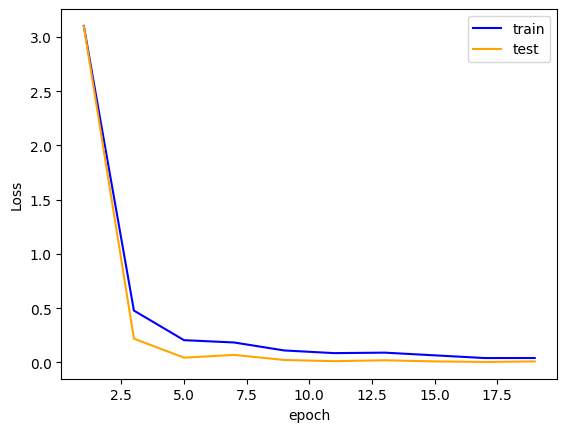

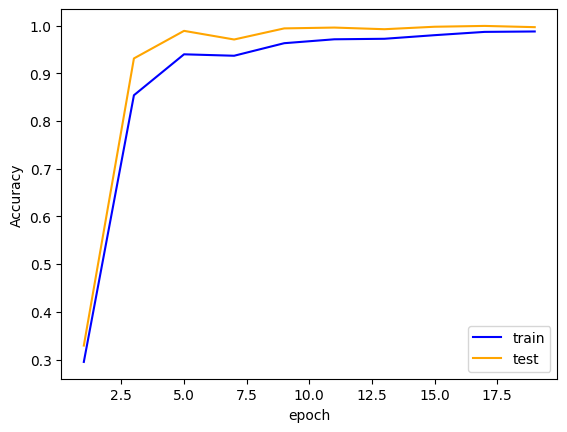

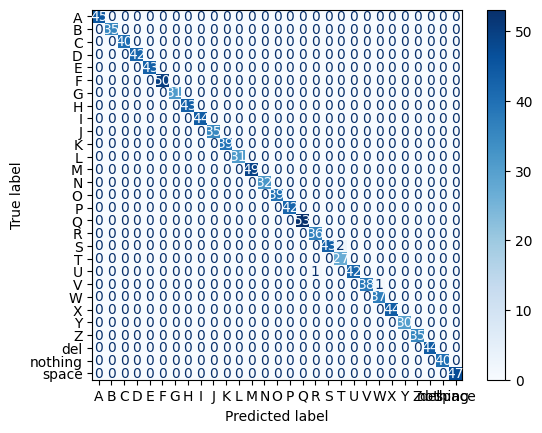

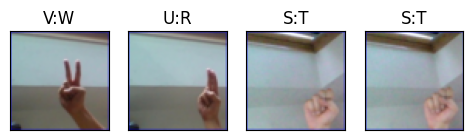

In [ ]:
myutils.show_learning_curve(history)

myutils.show_confusion_matrix(model=resnet50_model,
                              data_loader=OurASL_test_loader,
                              class_names=OurASL_class_names,
                              device=device)

# Display 100 images with "correct label : prediction"
myutils.show_misrecognizd_images(model=resnet50_model,
                         data_loader=OurASL_test_loader,
                         img_shape=(3, 64, 64),
                         class_names=OurASL_class_names,
                         device=device)

In [ ]:
### reference: https://qiita.com/a2kiti/items/f32de4f51a31d609e5a5

import IPython
from google.colab import output
import cv2
import numpy as np
from PIL import Image
from io import BytesIO
import base64

def run(img_str):
    #decode to image
    decimg = base64.b64decode(img_str.split(',')[1], validate=True)
    decimg = Image.open(BytesIO(decimg))


    #############your process###############
    img = OurASL_transform_test(decimg)
    img = img.unsqueeze(0)
    img = img.to(device)
    outputs = resnet50_model(img)
    #outputs = rn50_model(img)
    #outputs = model_mobilenet_v3_small(img)

    prediction = torch.max(outputs, 1)[1]
    pred_class = OurASL_class_names[prediction[0]]

    decimg = np.array(decimg, dtype=np.uint8);
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    out_img = decimg
    cv2.putText(out_img, pred_class, (10, 30), fontFace = cv2.FONT_HERSHEY_DUPLEX, fontScale = 1.0, color = (0,0,0))

    #############your process###############

    #encode to string
    _, encimg = cv2.imencode(".jpg", out_img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
    img_str = encimg.tobytes()
    img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
    return IPython.display.JSON({'img_str': img_str})

output.register_callback('notebook.run', run)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js

def use_cam(quality=0.8):
  js = Javascript('''
    async function useCam(quality) {
      const div = document.createElement('div');
      document.body.appendChild(div);
      //video element
      const video = document.createElement('video');
      video.style.display = 'None';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      //canvas for display. frame rate is depending on display size and jpeg quality.
      display_size = 500
      const src_canvas = document.createElement('canvas');
      src_canvas.width  = display_size;
      src_canvas.height = display_size * video.videoHeight / video.videoWidth;
      const src_canvasCtx = src_canvas.getContext('2d');
      src_canvasCtx.translate(src_canvas.width, 0);
      src_canvasCtx.scale(-1, 1);
      div.appendChild(src_canvas);

      const dst_canvas = document.createElement('canvas');
      dst_canvas.width  = src_canvas.width;
      dst_canvas.height = src_canvas.height;
      const dst_canvasCtx = dst_canvas.getContext('2d');
      div.appendChild(dst_canvas);

      //exit button
      const btn_div = document.createElement('div');
      document.body.appendChild(btn_div);
      const exit_btn = document.createElement('button');
      exit_btn.textContent = 'Exit';
      var exit_flg = true
      exit_btn.onclick = function() {exit_flg = false};
      btn_div.appendChild(exit_btn);

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      var send_num = 0
      // loop
      _canvasUpdate();
      async function _canvasUpdate() {
            src_canvasCtx.drawImage(video, 0, 0, video.videoWidth, video.videoHeight, 0, 0, src_canvas.width, src_canvas.height);
            if (send_num<1){
                send_num += 1
                const img = src_canvas.toDataURL('image/jpeg', quality);
                const result = google.colab.kernel.invokeFunction('notebook.run', [img], {});
                result.then(function(value) {
                    parse = JSON.parse(JSON.stringify(value))["data"]
                    parse = JSON.parse(JSON.stringify(parse))["application/json"]
                    parse = JSON.parse(JSON.stringify(parse))["img_str"]
                    var image = new Image()
                    image.src = parse;
                    image.onload = function(){dst_canvasCtx.drawImage(image, 0, 0)}
                    send_num -= 1
                })
            }
            if (exit_flg){
                requestAnimationFrame(_canvasUpdate);
            }else{
                stream.getVideoTracks()[0].stop();
            }
      };
    }
    ''')
  display(js)
  data = eval_js('useCam({})'.format(quality))

In [ ]:
use_cam()